In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

In [140]:
# Загрузка данных из Yahoo Finance
start_date = '2022-01-01'
end_date = '2023-01-01'
oil_data = yf.download('BZ=F', start=start_date, end=end_date)
print(oil_data.head())
usd_rub_data = yf.download('RUB=X', start=start_date, end=end_date)
print(usd_rub_data.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price       Adj Close      Close       High        Low       Open Volume
Ticker           BZ=F       BZ=F       BZ=F       BZ=F       BZ=F   BZ=F
Date                                                                    
2022-01-03  78.980003  78.980003  79.279999  77.040001  77.940002  27224
2022-01-04  80.000000  80.000000  80.550003  78.599998  78.949997  31321
2022-01-05  80.800003  80.800003  81.489998  79.550003  80.080002  35152
2022-01-06  81.989998  81.989998  82.839996  79.629997  80.150002  41582
2022-01-07  81.750000  81.750000  82.989998  81.440002  82.059998  29501
Price       Adj Close      Close       High        Low       Open Volume
Ticker          RUB=X      RUB=X      RUB=X      RUB=X      RUB=X  RUB=X
Date                                                                    
2022-01-03  74.986000  74.986000  75.185600  74.159401  75.185600      0
2022-01-04  74.371803  74.371803  75.568001  74.361298  74.372803      0
2022-01-05  75.263000  75.263000  76.122902  75.168

In [142]:
# Извлечение необходимых цен
oil_close = oil_data['Close'].dropna()
print(oil_close.head())
usd_rub_close = usd_rub_data['Close'].dropna()
print(usd_rub_close.head())

Ticker           BZ=F
Date                 
2022-01-03  78.980003
2022-01-04  80.000000
2022-01-05  80.800003
2022-01-06  81.989998
2022-01-07  81.750000
Ticker          RUB=X
Date                 
2022-01-03  74.986000
2022-01-04  74.371803
2022-01-05  75.263000
2022-01-06  76.661598
2022-01-07  76.353699


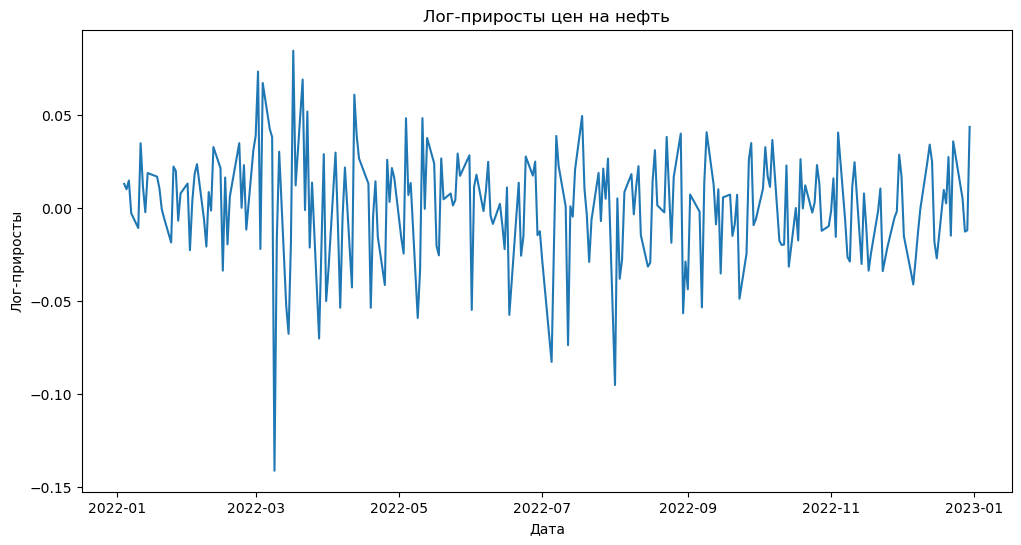

ADF Статистика: -7.873644134810675
p-value: 4.90929268932584e-12
Лог-приросты цен на нефть стационарны (на уровне значимости 5%).


In [144]:
# Задача 1: Проверка на стационарность ряда из лог-приростов цены на нефть

# Расчет логарифмических приростов
log_returns_oil = np.log(oil_close).diff().dropna()

# Визуализация лог-приростов
plt.figure(figsize=(12, 6))
plt.plot(log_returns_oil)
plt.title('Лог-приросты цен на нефть')
plt.xlabel('Дата')
plt.ylabel('Лог-приросты')
plt.show()

# ADF-тест для проверки стационарности
adf_result = adfuller(log_returns_oil)

# Вывод результатов
print('ADF Статистика:', adf_result[0])
print('p-value:', adf_result[1])

# Интерпретация
if adf_result[1] < 0.05:
    print("Лог-приросты цен на нефть стационарны (на уровне значимости 5%).")
else:
    print("Лог-приросты цен на нефть не стационарны (на уровне значимости 5%).")

                            OLS Regression Results                            
Dep. Variable:                USD_RUB   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     18.71
Date:                Thu, 21 Nov 2024   Prob (F-statistic):           2.21e-05
Time:                        22:36:52   Log-Likelihood:                -1047.5
No. Observations:                 251   AIC:                             2099.
Df Residuals:                     249   BIC:                             2106.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.0337      8.456      4.025      0.0

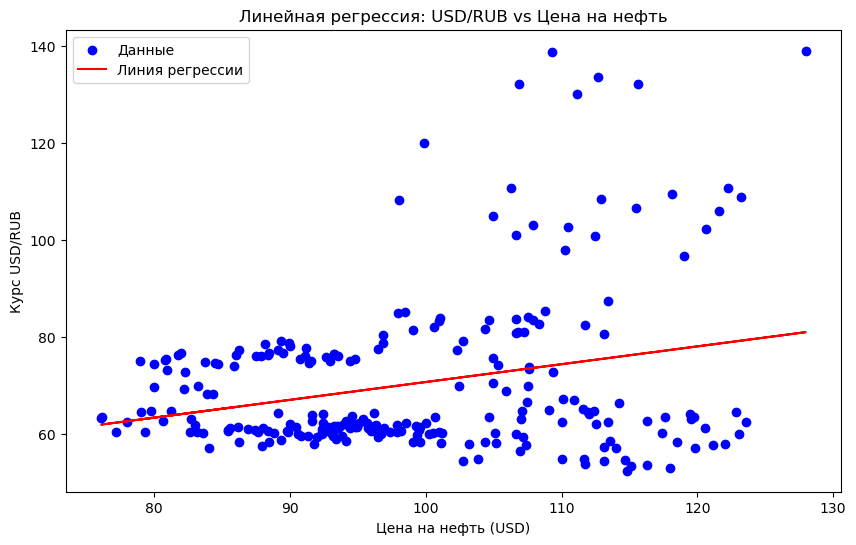

In [147]:
# Задача 2: Линейная регрессия курса доллара к цене на нефть

# Формируем единый DataFrame, объединяя данные по индексу даты
data = pd.DataFrame(index=usd_rub_data.index)
data['USD_RUB'] = usd_rub_close
data['Oil'] = oil_close

# Удаляем строки с пропущенными значениями
data.dropna(inplace=True)

# Определяем независимую (X) и зависимую (y) переменные
X = data['Oil']
y = data['USD_RUB']

# Добавляем константу к X для учета свободного члена в модели
X = sm.add_constant(X)

# Строим модель линейной регрессии
model = sm.OLS(y, X).fit()

# Выводим результаты регрессии
print(model.summary())

# Проверка значимости параметров
alpha = 0.05
params = model.params
p_values = model.pvalues

print("\nПроверка значимости параметров:")
for param, p_value in p_values.items():
    if p_value < alpha:
        print(f"Параметр {param} значим (p-value = {p_value:.4f} < {alpha})")
    else:
        print(f"Параметр {param} не значим (p-value = {p_value:.4f} >= {alpha})")
        
# Визуализация
plt.figure(figsize=(10, 6))
plt.scatter(data['Oil'], data['USD_RUB'], color='blue', label='Данные')
plt.plot(data['Oil'], model.predict(X), color='red', label='Линия регрессии')
plt.xlabel('Цена на нефть (USD)')
plt.ylabel('Курс USD/RUB')
plt.title('Линейная регрессия: USD/RUB vs Цена на нефть')
plt.legend()
plt.show()


                            OLS Regression Results                            
Dep. Variable:            Log_USD_RUB   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     12.60
Date:                Thu, 21 Nov 2024   Prob (F-statistic):           0.000462
Time:                        22:38:56   Log-Likelihood:                 57.227
No. Observations:                 251   AIC:                            -110.5
Df Residuals:                     249   BIC:                            -103.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5508      0.474      5.383      0.0

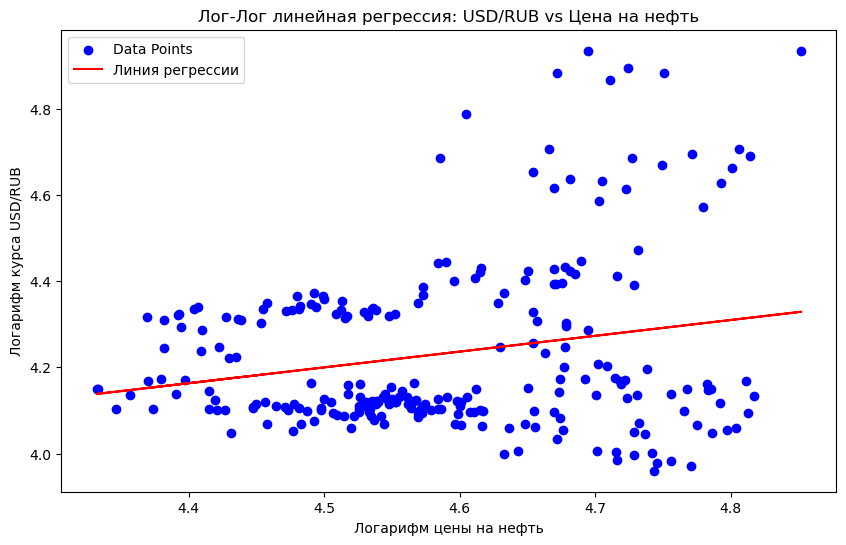

In [149]:
# Задача 3: Линейная регрессия логарифма курса доллара к логарифму цены на нефть
#Применяем логарифмическую трансформацию к данным
data['Log_USD_RUB'] = np.log(data['USD_RUB'])
data['Log_Oil'] = np.log(data['Oil'])

# Определяем независимую (X) и зависимую (y) переменные
X = data['Log_Oil']
y = data['Log_USD_RUB']

# Добавляем константу к X для учета свободного члена в модели
X = sm.add_constant(X)

# Строим модель линейной регрессии
model = sm.OLS(y, X).fit()

# Выводим результаты регрессии
print(model.summary())

# Проверка значимости параметров
alpha = 0.05
params = model.params
p_values = model.pvalues

print("\nПроверка значимости параметров:")
for param, p_value in p_values.items():
    if p_value < alpha:
        print(f"Параметр {param} значим (p-value = {p_value:.4f} < {alpha})")
    else:
        print(f"Параметр {param} не значим (p-value = {p_value:.4f} >= {alpha})")
        
# Визуализация
plt.figure(figsize=(10, 6))
plt.scatter(data['Log_Oil'], data['Log_USD_RUB'], color='blue', label='Data Points')
plt.plot(data['Log_Oil'], model.predict(X), color='red', label='Линия регрессии')
plt.xlabel('Логарифм цены на нефть')
plt.ylabel('Логарифм курса USD/RUB')
plt.title('Лог-Лог линейная регрессия: USD/RUB vs Цена на нефть')
plt.legend()
plt.show()
